# MNIST Problem

![](ex/2021-06-13_101245.png)

![](ex/2021-06-13_101429.png)

# Model

![](ex/2021-06-13_101640.png)

# 程序

![](ex/2021-06-13_101952.png)

## Step 1 Prepare datasets

In [113]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

In [114]:
mnist_dataset, mnist_info = tfds.load(name='mnist',with_info=True, as_supervised=True)

In [115]:
mnist_info

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_path='C:\\Users\\clin8\\tensorflow_datasets\\mnist\\3.0.1',
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
)

In [61]:
mnist_train, mnist_test = mnist_dataset['train'], mnist_dataset['test']

num_validation_samples = 0.1 * mnist_info.splits['train'].num_examples
# 確認是 integer
num_validation_samples = tf.cast(num_validation_samples, tf.int64)

num_test_samples = mnist_info.splits['test'].num_examples
num_test_samples = tf.cast(num_test_samples, tf.int64)

In [42]:
def scale(image, label):
    """
    將 image 的 gray_scale 的值變成 0 - 1
    此功能類似於 dataset.map(*function*)
    """
    image = tf.cast(image, tf.float32)  # tf.cast(x, dtype, name=None) 此函式是型別轉換函式，把x的型別轉換成dtype指定的型別
    image /= 255.    # . 是因為指定為 float
    return image, label

# 這個 .map() 就像是一個 lambda, 把 dataset 裏面的值都做一翻處理

scaled_train_and_validation_data = mnist_train.map(scale)
test_data = mnist_test.map(scale)

In [43]:
BUFFER_SIZE = 10000

suffled_train_and_validation_data = scaled_train_and_validation_data.shuffle(BUFFER_SIZE)
validation_data = suffled_train_and_validation_data.take(num_validation_samples)
train_data = suffled_train_and_validation_data.skip(num_validation_samples)

In [44]:
# tf.data.dataset.batch() 每一次幾筆資料丟上去

BATCH_SIZE = 100
# SGD 和 GD 的差異就在 batch, 可以用來加速修正，通常可以把 BATCH_SIZE 修到 BUFFER_SIZE 的 1/10 - 1/100
train_data = train_data.batch(BATCH_SIZE)

# Validation 不做 backpropagation, 所以可以做一次就好
validation_data = validation_data.batch(num_validation_samples)

# Test Data 一樣不必做 batch
test_data = test_data.batch(num_test_samples)

# Validation Data 的 format
validation_inputs, validation_targets = next(iter(validation_data))

## Step 2 Modeling

In [48]:
input_size = 784
output_size = 10
hidden_layer_size = 50  # 有兩層，可以設定為不同的 size

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28,28,1)),
    tf.keras.layers.Dense(hidden_layer_size, activation='relu'),
    tf.keras.layers.Dense(hidden_layer_size, activation='relu'),
    tf.keras.layers.Dense(output_size, activation='softmax')
])

## Step 3 optimazer, loss function

optimizer > adam

loss function: 
> binary_crossentropy: 通常用在 binary encoding

> categorical_crossentropy: expects that you've on-hot encoded the targets

> sparse_categorical_crossentropy: applies on-hot encoding

In [49]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

## Training/Learning

In [50]:
NUM_EPOCHS = 5

model.fit(train_data, epochs=NUM_EPOCHS, validation_data=(validation_inputs, validation_targets), verbose=2)

Epoch 1/5
540/540 - 2s - loss: 0.3336 - accuracy: 0.9054 - val_loss: 0.1452 - val_accuracy: 0.9560
Epoch 2/5
540/540 - 2s - loss: 0.1345 - accuracy: 0.9599 - val_loss: 0.1109 - val_accuracy: 0.9665
Epoch 3/5
540/540 - 2s - loss: 0.0969 - accuracy: 0.9709 - val_loss: 0.0892 - val_accuracy: 0.9743
Epoch 4/5
540/540 - 2s - loss: 0.0733 - accuracy: 0.9782 - val_loss: 0.0736 - val_accuracy: 0.9778
Epoch 5/5
540/540 - 2s - loss: 0.0601 - accuracy: 0.9817 - val_loss: 0.0603 - val_accuracy: 0.9817


# Audiobooks Problem

In [23]:
import numpy as np
from sklearn import preprocessing
import tensorflow as tf

raw_csv_data = np.loadtxt('Audiobooks_data.csv', delimiter=',')

unscaled_inputs_all = raw_csv_data[:, 1:-1]      # 第一欄不要，最後一欄是結果，也不用

targets_all = raw_csv_data[:, -1]

## Balance the dataset

In [24]:
num_one_targets = int(np.sum(targets_all))
zero_targets_counter = 0
indices_to_remove = []

for i in range(targets_all.shape[0]):
    if targets_all[i] == 0:
        zero_targets_counter += 1
        if zero_targets_counter > num_one_targets:
            indices_to_remove.append(i)     # 把太多的 item number 放到這裏
            

unscaled_inputs_equal_priors = np.delete(unscaled_inputs_all, indices_to_remove, axis = 0)
targets_equal_priors = np.delete(targets_all, indices_to_remove, axis = 0)

## Standardize the inputs

In [25]:
scaled_inputs = preprocessing.scale(unscaled_inputs_equal_priors)
scaled_inputs

array([[ 1.18956512,  0.36398846,  0.67728889, ..., -0.8635056 ,
        -0.20536617, -0.77240946],
       [-0.33022754,  1.10843845, -0.08841391, ..., -0.8635056 ,
        -0.20536617,  1.16499791],
       [-2.50135991, -1.74528653,  0.67728889, ..., -0.8635056 ,
         2.23179102,  2.78305242],
       ...,
       [ 1.18956512,  0.36398846,  0.67728889, ..., -0.20129479,
        -0.20536617, -0.62337812],
       [ 1.18956512,  0.36398846,  0.27347444, ..., -0.20129479,
        -0.20536617,  0.21758442],
       [ 1.18956512,  0.36398846,  0.20727535, ..., -0.20129479,
        -0.20536617, -0.51692717]])

## Shuffle the data

In [26]:
shuffled_indices = np.arange(scaled_inputs.shape[0])
np.random.shuffle(shuffled_indices)

shuffled_inputs = scaled_inputs[shuffled_indices]
shuffled_targets = targets_equal_priors[shuffled_indices]

## Split train, validation, and test

In [27]:
samples_count = shuffled_inputs.shape[0]

train_samples_count = int(0.8*samples_count)
validation_samples_count = int(0.1*samples_count)
test_samples_count = samples_count - train_samples_count - validation_samples_count

train_inputs = shuffled_inputs[:train_samples_count]
train_targets = shuffled_targets[:train_samples_count]

validation_inputs = shuffled_inputs[train_samples_count: train_samples_count + validation_samples_count]
validation_targets = shuffled_targets[train_samples_count: train_samples_count + validation_samples_count]

test_inputs = shuffled_inputs[train_samples_count + validation_samples_count :]
test_targets = shuffled_targets[train_samples_count + validation_samples_count :]

In [28]:
np.savez('Audiobooks_data_train', inputs = train_inputs, targets = train_targets)
np.savez('Audiobooks_data_validation', inputs = validation_inputs, targets = validation_targets)
np.savez('Audiobooks_data_test', inputs = test_inputs, targets = test_targets)

## 如果要讀出來

In [41]:
npz = np.load('Audiobooks_data_train.npz')

train_inputs = npz['inputs'].astype(np.float)
train_targets = npz['targets'].astype(np.int)

npz = np.load('Audiobooks_data_validation.npz')
validation_inputs, validation_targets = npz['inputs'].astype(np.float), npz['targets'].astype(np.int)

npz = np.load('Audiobooks_data_test.npz')
test_inputs, test_targets = npz['inputs'].astype(np.float), npz['targets'].astype(np.int)

## Model

![](ex/2021-06-13_230643.png)

In [43]:
# 可以 reuse mnist
input_size = 10
output_size = 2
hidden_layer_size = 50  # 有兩層，可以設定為不同的 size

model = tf.keras.Sequential([
    tf.keras.layers.Dense(hidden_layer_size, activation='relu'),
    tf.keras.layers.Dense(hidden_layer_size, activation='relu'),
    tf.keras.layers.Dense(output_size, activation='softmax')
])

In [44]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [33]:
batch_size = 100
max_epochs = 100
model.fit(train_inputs, train_targets, batch_size=batch_size, epochs = max_epochs,
         validation_data=(validation_inputs, validation_targets),
         verbose = 2)

Epoch 1/100
36/36 - 2s - loss: 0.5196 - accuracy: 0.8030 - val_loss: 0.3884 - val_accuracy: 0.8702
Epoch 2/100
36/36 - 0s - loss: 0.3480 - accuracy: 0.8826 - val_loss: 0.3189 - val_accuracy: 0.8725
Epoch 3/100
36/36 - 0s - loss: 0.3080 - accuracy: 0.8877 - val_loss: 0.3057 - val_accuracy: 0.8859
Epoch 4/100
36/36 - 0s - loss: 0.2909 - accuracy: 0.8902 - val_loss: 0.2902 - val_accuracy: 0.8904
Epoch 5/100
36/36 - 0s - loss: 0.2792 - accuracy: 0.8938 - val_loss: 0.2896 - val_accuracy: 0.8904
Epoch 6/100
36/36 - 0s - loss: 0.2718 - accuracy: 0.8972 - val_loss: 0.2785 - val_accuracy: 0.8904
Epoch 7/100
36/36 - 0s - loss: 0.2642 - accuracy: 0.8986 - val_loss: 0.2810 - val_accuracy: 0.8971
Epoch 8/100
36/36 - 0s - loss: 0.2591 - accuracy: 0.9008 - val_loss: 0.2701 - val_accuracy: 0.8949
Epoch 9/100
36/36 - 0s - loss: 0.2565 - accuracy: 0.9008 - val_loss: 0.2675 - val_accuracy: 0.9016
Epoch 10/100
36/36 - 0s - loss: 0.2532 - accuracy: 0.9019 - val_loss: 0.2611 - val_accuracy: 0.9038
Epoch 11/

## Overfitting

In [46]:
# 其實只是在 model.fit 裏，加上 callbacks
batch_size = 100
max_epochs = 100
early_stopping = tf.keras.callbacks.EarlyStopping(patience=2)

model.fit(train_inputs, train_targets, batch_size=batch_size, epochs = max_epochs, callbacks=[early_stopping],
         validation_data=(validation_inputs, validation_targets),
         verbose = 2)

Epoch 1/100
36/36 - 0s - loss: 0.2430 - accuracy: 0.9067 - val_loss: 0.2513 - val_accuracy: 0.9016
Epoch 2/100
36/36 - 0s - loss: 0.2400 - accuracy: 0.9072 - val_loss: 0.2539 - val_accuracy: 0.9038
Epoch 3/100
36/36 - 0s - loss: 0.2384 - accuracy: 0.9075 - val_loss: 0.2497 - val_accuracy: 0.9038
Epoch 4/100
36/36 - 0s - loss: 0.2370 - accuracy: 0.9081 - val_loss: 0.2460 - val_accuracy: 0.9038
Epoch 5/100
36/36 - 0s - loss: 0.2350 - accuracy: 0.9125 - val_loss: 0.2497 - val_accuracy: 0.9038
Epoch 6/100
36/36 - 0s - loss: 0.2373 - accuracy: 0.9103 - val_loss: 0.2419 - val_accuracy: 0.9083
Epoch 7/100
36/36 - 0s - loss: 0.2341 - accuracy: 0.9100 - val_loss: 0.2420 - val_accuracy: 0.9083
Epoch 8/100
36/36 - 0s - loss: 0.2335 - accuracy: 0.9109 - val_loss: 0.2432 - val_accuracy: 0.9060


In [47]:
test_loss, test_accuracy = model.evaluate(test_inputs, test_targets)

14/14 [==============================] - 0s 2ms/step - loss: 0.2283 - accuracy: 0.9196


# Linear Regression Case

In [2]:
import numpy as np
import pandas as pd
import seaborn as sb
import tensorflow as tf
from tensorflow import keras as ks
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from tensorflow.estimator import LinearRegressor
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
print(tf.__version__)

2.5.0


In [3]:
boston_load = datasets.load_boston()

# 可以看一下這個數據集的東西，知道我們大概要如何使用

boston_load

{'data': array([[6.3200e-03, 1.8000e+01, 2.3100e+00, ..., 1.5300e+01, 3.9690e+02,
         4.9800e+00],
        [2.7310e-02, 0.0000e+00, 7.0700e+00, ..., 1.7800e+01, 3.9690e+02,
         9.1400e+00],
        [2.7290e-02, 0.0000e+00, 7.0700e+00, ..., 1.7800e+01, 3.9283e+02,
         4.0300e+00],
        ...,
        [6.0760e-02, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9690e+02,
         5.6400e+00],
        [1.0959e-01, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9345e+02,
         6.4800e+00],
        [4.7410e-02, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9690e+02,
         7.8800e+00]]),
 'target': array([24. , 21.6, 34.7, 33.4, 36.2, 28.7, 22.9, 27.1, 16.5, 18.9, 15. ,
        18.9, 21.7, 20.4, 18.2, 19.9, 23.1, 17.5, 20.2, 18.2, 13.6, 19.6,
        15.2, 14.5, 15.6, 13.9, 16.6, 14.8, 18.4, 21. , 12.7, 14.5, 13.2,
        13.1, 13.5, 18.9, 20. , 21. , 24.7, 30.8, 34.9, 26.6, 25.3, 24.7,
        21.2, 19.3, 20. , 16.6, 14.4, 19.4, 19.7, 20.5, 25. , 23.4, 18.9,
        35.4, 24.7, 3

In [4]:
print(boston_load['DESCR'])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [5]:
# 先分類

feature_columns = boston_load.feature_names
target_column = boston_load.target
boston_data = pd.DataFrame(boston_load.data, columns=feature_columns).astype(np.float32)
boston_data.head()
boston_data['MEDV'] = target_column.astype(np.float32)   # 就是 target 的值
boston_data.head()

CRIM    ZN  INDUS  CHAS    NOX     RM        AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31   0.0  0.538  6.575  65.199997  4.0900  1.0  296.0   
1  0.02731   0.0   7.07   0.0  0.469  6.421  78.900002  4.9671  2.0  242.0   
2  0.02729   0.0   7.07   0.0  0.469  7.185  61.099998  4.9671  2.0  242.0   
3  0.03237   0.0   2.18   0.0  0.458  6.998  45.799999  6.0622  3.0  222.0   
4  0.06905   0.0   2.18   0.0  0.458  7.147  54.200001  6.0622  3.0  222.0   

     PTRATIO           B  LSTAT       MEDV  
0  15.300000  396.899994   4.98  24.000000  
1  17.799999  396.899994   9.14  21.600000  
2  17.799999  392.829987   4.03  34.700001  
3  18.700001  394.630005   2.94  33.400002  
4  18.700001  396.899994   5.33  36.200001

## Prepare

In [6]:
# boston_data.shape

# 查一下有沒有 null 的值

boston_data.isnull().sum()

# 蠻好的

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

In [7]:
# 先要預處理數據

def norm(x):
    stats = x.describe().transpose()
    return (x - stats['mean']) / stats['std']

In [8]:
# 留一份 stats 數據，後面可以推回來

boston_stats = boston_data.describe().transpose()
boston_stats

count        mean         std        min         25%         50%  \
CRIM     506.0    3.613524    8.601545    0.00632    0.082045    0.256510   
ZN       506.0   11.363636   23.322453    0.00000    0.000000    0.000000   
INDUS    506.0   11.136780    6.860353    0.46000    5.190000    9.690000   
CHAS     506.0    0.069170    0.253994    0.00000    0.000000    0.000000   
NOX      506.0    0.554695    0.115878    0.38500    0.449000    0.538000   
RM       506.0    6.284634    0.702617    3.56100    5.885500    6.208500   
AGE      506.0   68.574898   28.148861    2.90000   45.025000   77.500000   
DIS      506.0    3.795043    2.105710    1.12960    2.100175    3.207450   
RAD      506.0    9.549407    8.707259    1.00000    4.000000    5.000000   
TAX      506.0  408.237152  168.537109  187.00000  279.000000  330.000000   
PTRATIO  506.0   18.455534    2.164946   12.60000   17.400000   19.050000   
B        506.0  356.674042   91.294861    0.32000  375.377487  391.440002   
LSTAT    506.0   12.653064    7.141061    1.73000    6.950000   11.360000   
MEDV     506.0   22.532806    9.197104    5.00000   17.025000   21.200001   

                75%         max  
CRIM       3.677083   88.976196  
ZN        12.500000  100.000000  
INDUS     18.100000   27.740000  
CHAS       0.000000    1.000000  
NOX        0.624000    0.871000  
RM         6.623500    8.780000  
AGE       94.074999  100.000000  
DIS        5.188425   12.126500  
RAD       24.000000   24.000000  
TAX      666.000000  711.000000  
PTRATIO   20.200001   22.000000  
B        396.225006  396.899994  
LSTAT     16.954999   37.970001  
MEDV      25.000000   50.000000

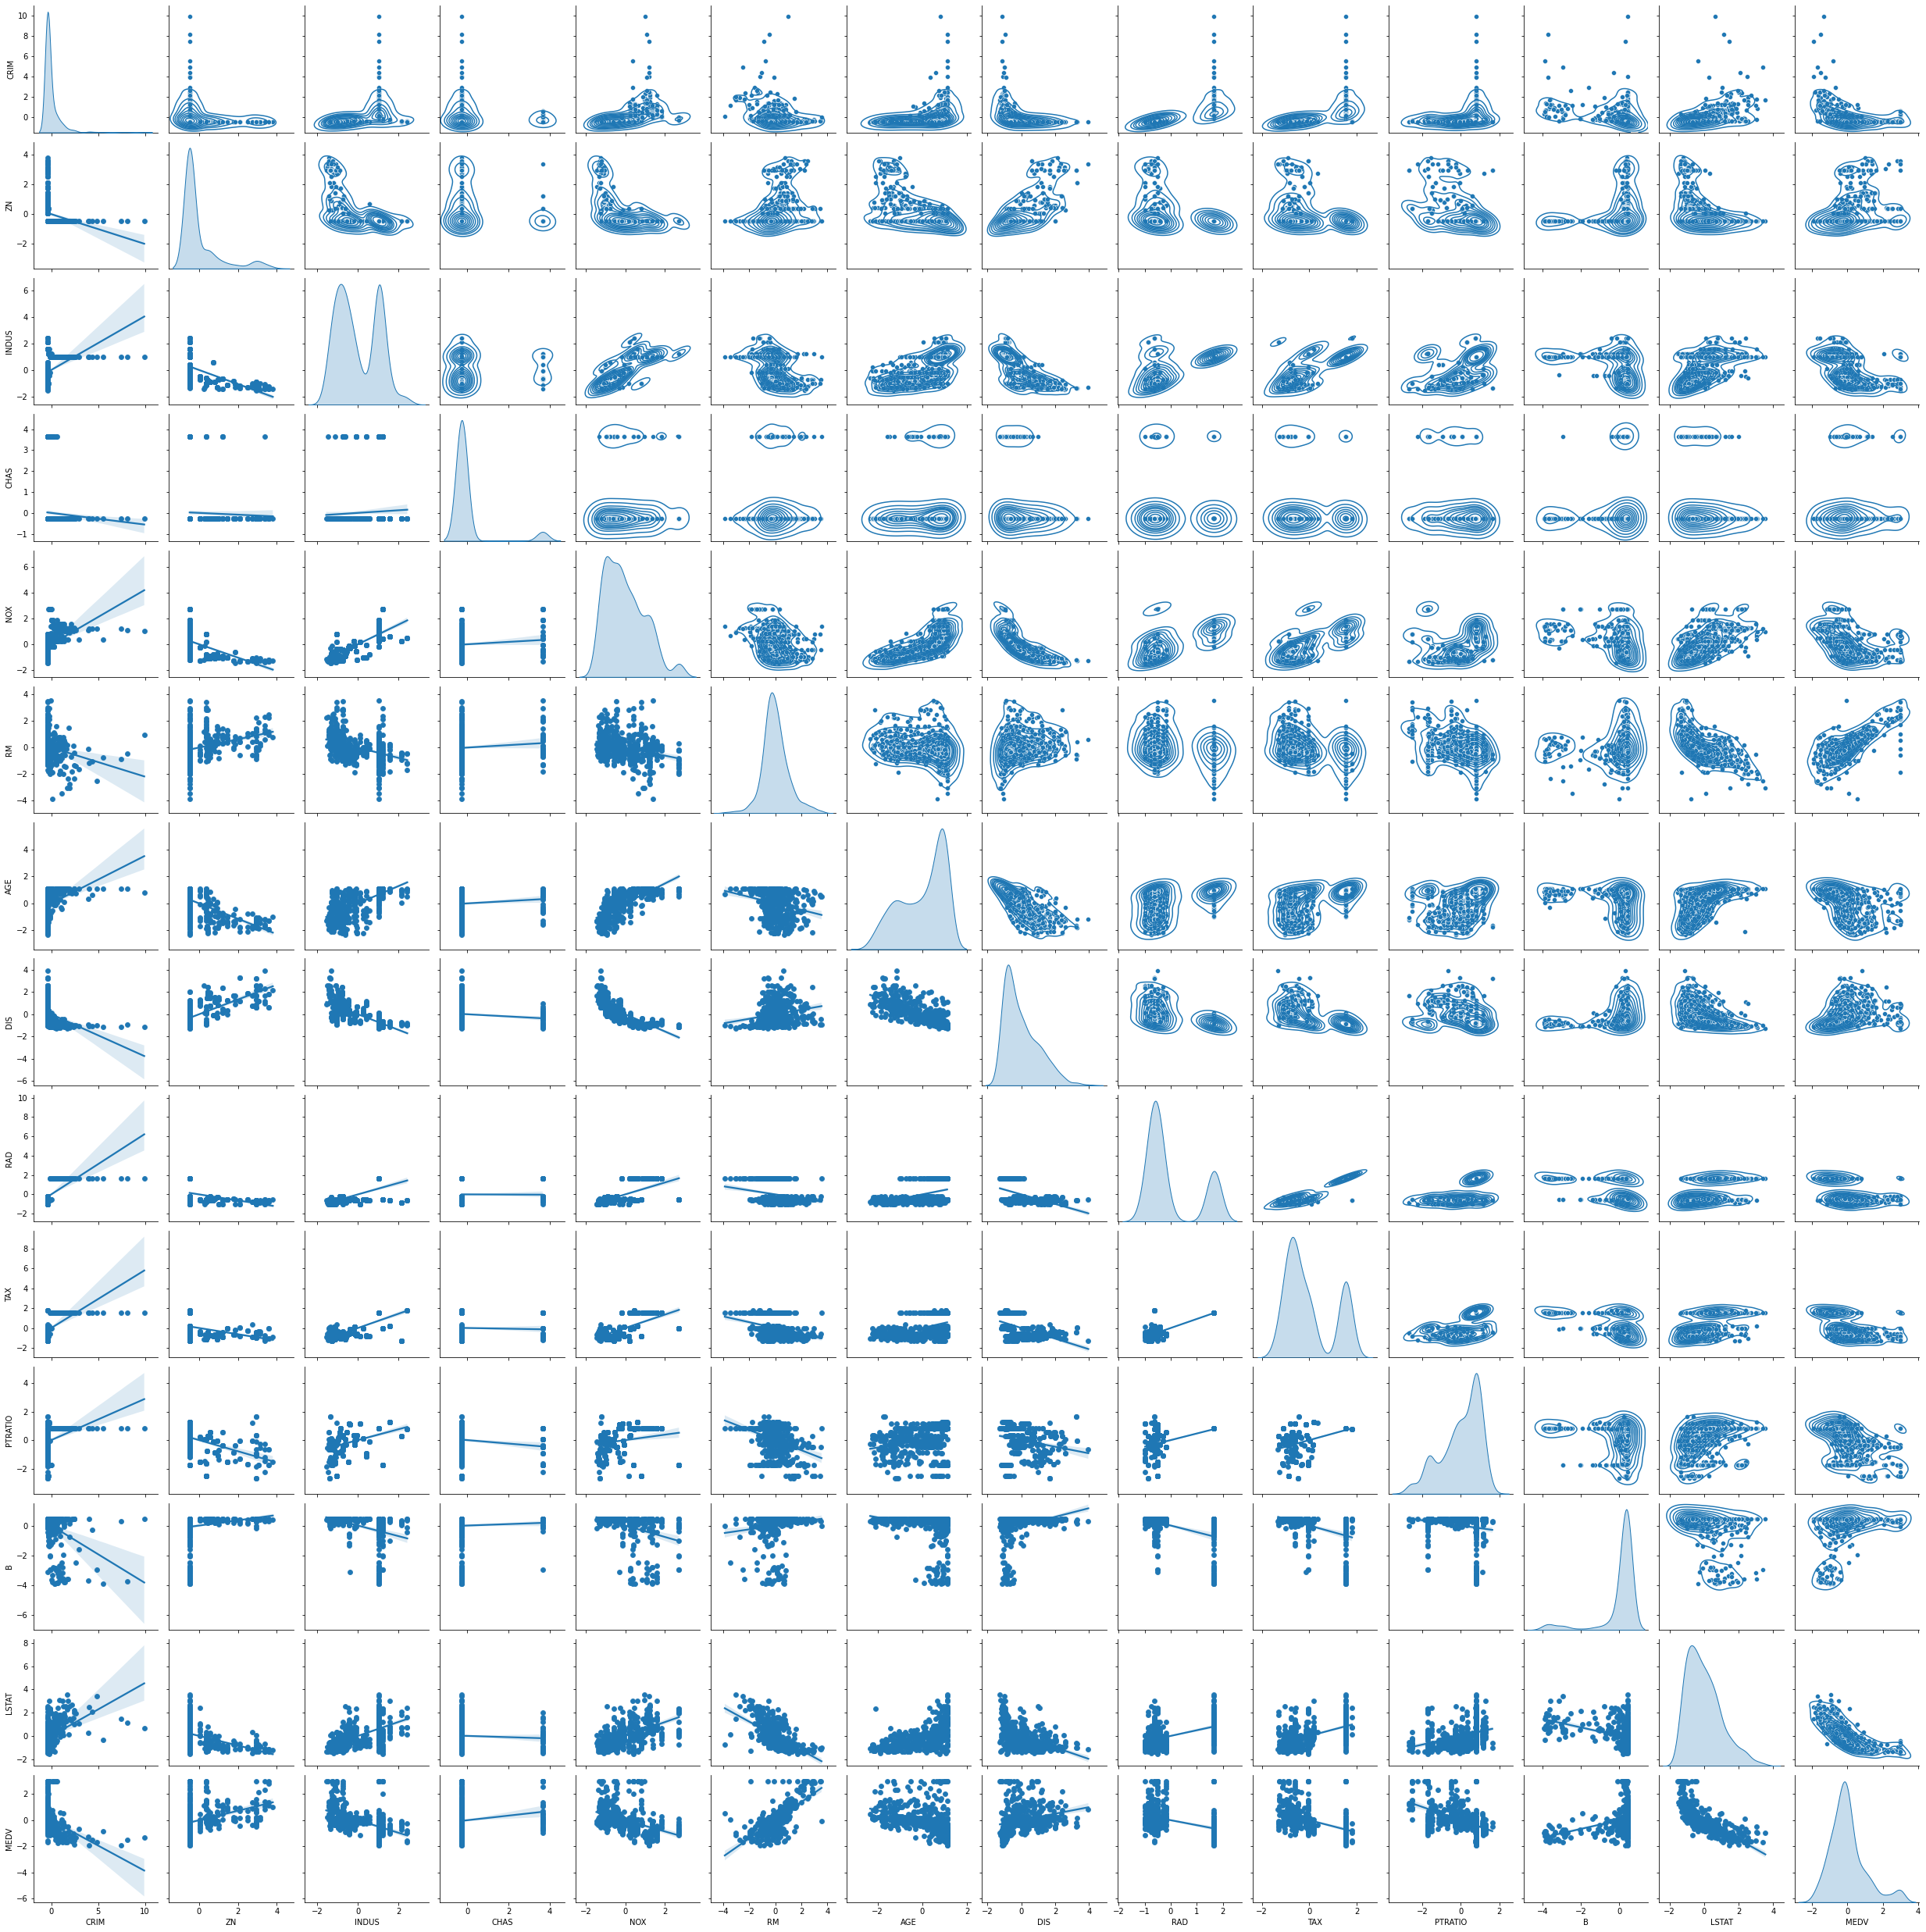

In [22]:
# Norm boston_data

normed_boston_data= norm(boston_data)

# 這個酷

pp = sb.pairplot(normed_boston_data, diag_kind='kde')
pp = pp.map_lower(sb.regplot)
pp = pp.map_upper(sb.kdeplot)

In [40]:
# Pandas 的 slicing 跟 numpy 稍有不同，類似 numpy 的操作要加 .iloc ， 但最簡單的反而是用 .loc

# X_data = boston_data.iloc[:,:-1]

X_data = normed_boston_data.loc[:,'CRIM': 'LSTAT']

X_data

CRIM        ZN     INDUS      CHAS       NOX        RM       AGE  \
0   -0.419367  0.284548 -1.286636 -0.272329 -0.144075  0.413263 -0.119895   
1   -0.416927 -0.487240 -0.592795 -0.272329 -0.739530  0.194083  0.366804   
2   -0.416929 -0.487240 -0.592795 -0.272329 -0.739530  1.281446 -0.265549   
3   -0.416338 -0.487240 -1.305586 -0.272329 -0.834458  1.015298 -0.809088   
4   -0.412074 -0.487240 -1.305586 -0.272329 -0.834458  1.227362 -0.510674   
..        ...       ...       ...       ...       ...       ...       ...   
501 -0.412820 -0.487240  0.115624 -0.272329  0.157968  0.438882  0.018654   
502 -0.414839 -0.487240  0.115624 -0.272329  0.157968 -0.234316  0.288648   
503 -0.413038 -0.487240  0.115624 -0.272329  0.157968  0.983986  0.796661   
504 -0.407361 -0.487240  0.115624 -0.272329  0.157968  0.724955  0.736268   
505 -0.414590 -0.487240  0.115624 -0.272329  0.157968 -0.362408  0.434302   

          DIS       RAD       TAX   PTRATIO         B     LSTAT  
0    0.140075 -0.981871 -0.665949 -1.457558  0.440616 -1.074499  
1    0.556609 -0.867024 -0.986353 -0.302795  0.440616 -0.491953  
2    0.556609 -0.867024 -0.986353 -0.302795  0.396035 -1.207532  
3    1.076671 -0.752178 -1.105022  0.112921  0.415751 -1.360171  
4    1.076671 -0.752178 -1.105022  0.112921  0.440616 -1.025487  
..        ...       ...       ...       ...       ...       ...  
501 -0.625178 -0.981871 -0.802418  1.175302  0.386834 -0.417734  
502 -0.715931 -0.981871 -0.802418  1.175302  0.440616 -0.500355  
503 -0.772919 -0.981871 -0.802418  1.175302  0.440616 -0.982076  
504 -0.667776 -0.981871 -0.802418  1.175302  0.402826 -0.864446  
505 -0.612640 -0.981871 -0.802418  1.175302  0.440616 -0.668397  

[506 rows x 13 columns]

In [41]:
# Y 不能 norm, 不然會出問題

Y_data = boston_data['MEDV']
Y_data

0      24.000000
1      21.600000
2      34.700001
3      33.400002
4      36.200001
         ...    
501    22.400000
502    20.600000
503    23.900000
504    22.000000
505    11.900000
Name: MEDV, Length: 506, dtype: float32

In [42]:
correlation_data = normed_boston_data.corr()

In [43]:
correlation_data.style.background_gradient(cmap='coolwarm', axis=None)

In [44]:
# Multicollinearity occurs when two or more independent variables (features) are strongly correlated. This can be a big deal in linear regression problems as it reduces the efficacy of the linear regression coefficient. By implication, you won’t have a clear insight into how the features affect the target variable. 

# VIF stands for Variable Inflation Factor. It is given by the inverse of 1 – R2 value. 
# For VIF scores equal to 1, it means there is no correlation at all. 
# If the VIF score ranges from 1 to 5, it means there’s a slight correlation. 
# While for VIF scores greater than 10, it means there is a strong correlation.

def create_vif(dataframe):
    ''' This function calculates the Variation Inflation Factors for each column and convert it into a dataframe'''
    
    #create an empty dataframe
    vif_table = pd.DataFrame()
    #populate the first column with the columns of the dataset
    vif_table['variables'] = dataframe.columns
    #calculate the VIF of each column and create a VIF column to store the number
    vif_table['VIF'] = [vif(dataframe.values, i) for i in range(dataframe.shape[1])]
    
    return vif_table

#print the VIF table for each variable
vif_result = create_vif(boston_data)
vif_result.style.background_gradient(cmap='coolwarm', axis=None)

# NOX, RM, AGE, PTRATIO 

In [45]:
# 發現一件事，有 norm 過和沒 norm 過的 dataset 在 VIF 有不同的表現

vif_result = create_vif(normed_boston_data)
vif_result.style.background_gradient(cmap='coolwarm', axis=None)

In [46]:
# Split data

X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, test_size=0.2, random_state=1)

In [49]:
y_test

307    28.200001
343    23.900000
47     16.600000
67     22.000000
362    20.799999
         ...    
92     22.900000
224    44.799999
110    21.700001
426    10.200000
443    15.400000
Name: MEDV, Length: 102, dtype: float32

## Modeling

In [67]:
#built the neural network architecture，先直接接 output
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(15, input_dim=13, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='linear'))

In [68]:
# 這樣子也行

model = tf.keras.Sequential([
    tf.keras.layers.Dense(15, input_dim=13, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear')
])

In [69]:
# mse = mean square error, mae = mean absolute error

model.compile(loss='mse', optimizer='adam', metrics=['mse', 'mae'])

In [70]:
#train the neural network on the train dataset
history = model.fit(X_train, y_train, epochs=100, validation_split=0.2)

Epoch 1/100
11/11 [==============================] - 0s 14ms/step - loss: 569.8915 - mse: 569.8915 - mae: 22.0836 - val_loss: 542.0020 - val_mse: 542.0020 - val_mae: 21.2911
Epoch 2/100
11/11 [==============================] - 0s 4ms/step - loss: 561.2885 - mse: 561.2885 - mae: 21.9070 - val_loss: 534.1262 - val_mse: 534.1262 - val_mae: 21.1276
Epoch 3/100
11/11 [==============================] - 0s 4ms/step - loss: 553.4957 - mse: 553.4957 - mae: 21.7380 - val_loss: 526.2747 - val_mse: 526.2747 - val_mae: 20.9642
Epoch 4/100
11/11 [==============================] - 0s 3ms/step - loss: 545.1813 - mse: 545.1813 - mae: 21.5605 - val_loss: 518.3928 - val_mse: 518.3928 - val_mae: 20.7952
Epoch 5/100
11/11 [==============================] - 0s 4ms/step - loss: 536.7158 - mse: 536.7158 - mae: 21.3767 - val_loss: 510.1008 - val_mse: 510.1008 - val_mae: 20.6157
Epoch 6/100
11/11 [==============================] - 0s 4ms/step - loss: 528.0460 - mse: 528.0460 - mae: 21.1826 - val_loss: 501.3948 

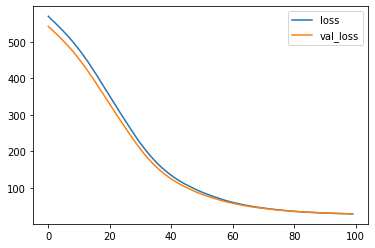

In [71]:
import matplotlib.pyplot as plt
%matplotlib inline

#plot the loss and validation loss of the dataset
history_df = pd.DataFrame(history.history)
plt.plot(history_df['loss'], label='loss')
plt.plot(history_df['val_loss'], label='val_loss')

plt.legend()

## Result

In [72]:
# 超過 epoch 50, 就沒多大用處了

#evaluate the model

model.evaluate(X_test, y_test, batch_size=128)

1/1 [==============================] - 0s 25ms/step - loss: 37.6961 - mse: 37.6961 - mae: 4.5793


[37.69613265991211, 37.69613265991211, 4.579331398010254]

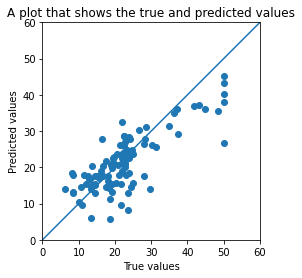

In [73]:
y_pred = model.predict(X_test).flatten()

a = plt.axes(aspect='equal')
plt.scatter(y_test, y_pred)
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.title('A plot that shows the true and predicted values')
plt.xlim([0, 60])
plt.ylim([0, 60])
plt.plot([0, 60], [0, 60])

In [77]:
# 改 model, 增加兩層 hidden layers

model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(15, input_dim=13, activation='relu'))
model.add(tf.keras.layers.Dense(7, activation='relu'))
model.add(tf.keras.layers.Dense(5, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='linear'))

model.compile(loss='mse', optimizer='adam', metrics=['mse', 'mae'])

hist2 = model.fit(X_train, y_train, epochs=200, validation_split=0.2)

Epoch 1/200
11/11 [==============================] - 1s 15ms/step - loss: 556.3010 - mse: 556.3010 - mae: 21.8060 - val_loss: 528.3018 - val_mse: 528.3018 - val_mae: 20.9585
Epoch 2/200
11/11 [==============================] - 0s 4ms/step - loss: 543.1866 - mse: 543.1866 - mae: 21.5033 - val_loss: 514.7589 - val_mse: 514.7589 - val_mae: 20.6600
Epoch 3/200
11/11 [==============================] - 0s 4ms/step - loss: 527.3827 - mse: 527.3827 - mae: 21.1393 - val_loss: 497.9712 - val_mse: 497.9712 - val_mae: 20.2862
Epoch 4/200
11/11 [==============================] - 0s 4ms/step - loss: 508.3914 - mse: 508.3914 - mae: 20.6830 - val_loss: 477.1031 - val_mse: 477.1031 - val_mae: 19.8113
Epoch 5/200
11/11 [==============================] - 0s 4ms/step - loss: 485.0133 - mse: 485.0133 - mae: 20.1256 - val_loss: 453.8310 - val_mse: 453.8310 - val_mae: 19.2708
Epoch 6/200
11/11 [==============================] - 0s 4ms/step - loss: 459.0861 - mse: 459.0861 - mae: 19.4793 - val_loss: 426.0410 

In [79]:
# epochs 200 果然有厲害 (overfitting ??)
#evaluate the model - 加兩層，還是有效 (但這算是 linear model 嗎??)

model.evaluate(X_test, y_test, batch_size=128)

1/1 [==============================] - 0s 27ms/step - loss: 9.6915 - mse: 9.6915 - mae: 2.3740


[9.69148063659668, 9.69148063659668, 2.3740315437316895]

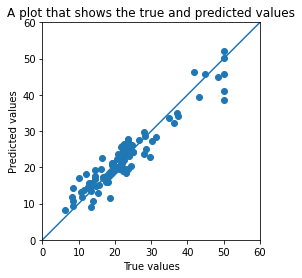

In [80]:
y_pred = model.predict(X_test).flatten()

a = plt.axes(aspect='equal')
plt.scatter(y_test, y_pred)
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.title('A plot that shows the true and predicted values')
plt.xlim([0, 60])
plt.ylim([0, 60])
plt.plot([0, 60], [0, 60])

# Logistic Regression

Iris

In [25]:
from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sb
from tensorflow import keras
from tensorflow.estimator import LinearClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score


In [2]:
import tensorflow_datasets as tfds
iris_dataset, iris_info = tfds.load(name='iris',with_info=True, as_supervised=True)
iris_info

tfds.core.DatasetInfo(
    name='iris',
    full_name='iris/2.0.0',
    description="""
    This is perhaps the best known database to be found in the pattern recognition
    literature. Fisher's paper is a classic in the field and is referenced
    frequently to this day. (See Duda & Hart, for example.) The data set contains
    3 classes of 50 instances each, where each class refers to a type of iris
    plant. One class is linearly separable from the other 2; the latter are NOT
    linearly separable from each other.
    """,
    homepage='https://archive.ics.uci.edu/ml/datasets/iris',
    data_path='C:\\Users\\clin8\\tensorflow_datasets\\iris\\2.0.0',
    download_size=4.44 KiB,
    dataset_size=7.62 KiB,
    features=FeaturesDict({
        'features': Tensor(shape=(4,), dtype=tf.float32),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=3),
    }),
    supervised_keys=('features', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_

In [3]:
iris_data = iris_dataset['train']

In [4]:
# 要看 iris_data 的樣子，就把 tensorflow dataset 物件 轉回 numpy, 再轉回 list

list(iris_data.as_numpy_iterator())

[(array([5.1, 3.4, 1.5, 0.2], dtype=float32), 0),
 (array([7.7, 3. , 6.1, 2.3], dtype=float32), 2),
 (array([5.7, 2.8, 4.5, 1.3], dtype=float32), 1),
 (array([6.8, 3.2, 5.9, 2.3], dtype=float32), 2),
 (array([5.2, 3.4, 1.4, 0.2], dtype=float32), 0),
 (array([5.6, 2.9, 3.6, 1.3], dtype=float32), 1),
 (array([5.5, 2.6, 4.4, 1.2], dtype=float32), 1),
 (array([5.5, 2.4, 3.7, 1. ], dtype=float32), 1),
 (array([4.6, 3.4, 1.4, 0.3], dtype=float32), 0),
 (array([7.7, 2.8, 6.7, 2. ], dtype=float32), 2),
 (array([7. , 3.2, 4.7, 1.4], dtype=float32), 1),
 (array([4.6, 3.2, 1.4, 0.2], dtype=float32), 0),
 (array([6.5, 3. , 5.2, 2. ], dtype=float32), 2),
 (array([5.5, 4.2, 1.4, 0.2], dtype=float32), 0),
 (array([5.4, 3.9, 1.3, 0.4], dtype=float32), 0),
 (array([5. , 3.5, 1.3, 0.3], dtype=float32), 0),
 (array([5.1, 3.8, 1.5, 0.3], dtype=float32), 0),
 (array([4.8, 3. , 1.4, 0.1], dtype=float32), 0),
 (array([6.5, 3. , 5.8, 2.2], dtype=float32), 2),
 (array([7.6, 3. , 6.6, 2.1], dtype=float32), 2),


In [5]:
num_examples = iris_info.splits['train'].num_examples

In [6]:
train_num = int(0.7*num_examples)
validate_num = int(0.2*num_examples)
test_num = num_examples - train_num - validate_num

print(train_num, validate_num, test_num)

105 30 15


In [8]:
# 算了，換一種方法
import os

train_dataset_url = "https://storage.googleapis.com/download.tensorflow.org/data/iris_training.csv"

train_dataset_fp = tf.keras.utils.get_file(fname=os.path.basename(train_dataset_url),
                                           origin=train_dataset_url)

print("Local copy of the dataset file: {}".format(train_dataset_fp))

Local copy of the dataset file: C:\Users\clin8\.keras\datasets\iris_training.csv


In [9]:
iris = pd.read_csv('./TF-examples/iris_training.csv')

In [10]:
iris.head()

120    4  setosa  versicolor  virginica
0  6.4  2.8     5.6         2.2          2
1  5.0  2.3     3.3         1.0          1
2  4.9  2.5     4.5         1.7          2
3  4.9  3.1     1.5         0.1          0
4  5.7  3.8     1.7         0.3          0

In [11]:
iris.shape

(120, 5)

In [12]:
column_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']

feature_names = column_names[:-1]
label_name = column_names[-1]

In [13]:
## species:

## 0: Iris setosa
## 1: Iris versicolor
## 2: Iris virginica

class_names = ['Iris setosa', 'Iris versicolor', 'Iris virginica']

In [14]:
iris.columns = column_names
iris.head()

sepal_length  sepal_width  petal_length  petal_width  species
0           6.4          2.8           5.6          2.2        2
1           5.0          2.3           3.3          1.0        1
2           4.9          2.5           4.5          1.7        2
3           4.9          3.1           1.5          0.1        0
4           5.7          3.8           1.7          0.3        0

## Prepare

In [15]:
# 查 null
iris.isnull().sum()

sepal_length    0
sepal_width     0
petal_length    0
petal_width     0
species         0
dtype: int64

              count      mean       std  min    25%  50%    75%  max
sepal_length  120.0  5.845000  0.868578  4.4  5.075  5.8  6.425  7.9
sepal_width   120.0  3.065000  0.427156  2.0  2.800  3.0  3.300  4.4
petal_length  120.0  3.739167  1.822100  1.0  1.500  4.4  5.100  6.9
petal_width   120.0  1.196667  0.782039  0.1  0.300  1.3  1.800  2.5
species       120.0  1.000000  0.840168  0.0  0.000  1.0  2.000  2.0


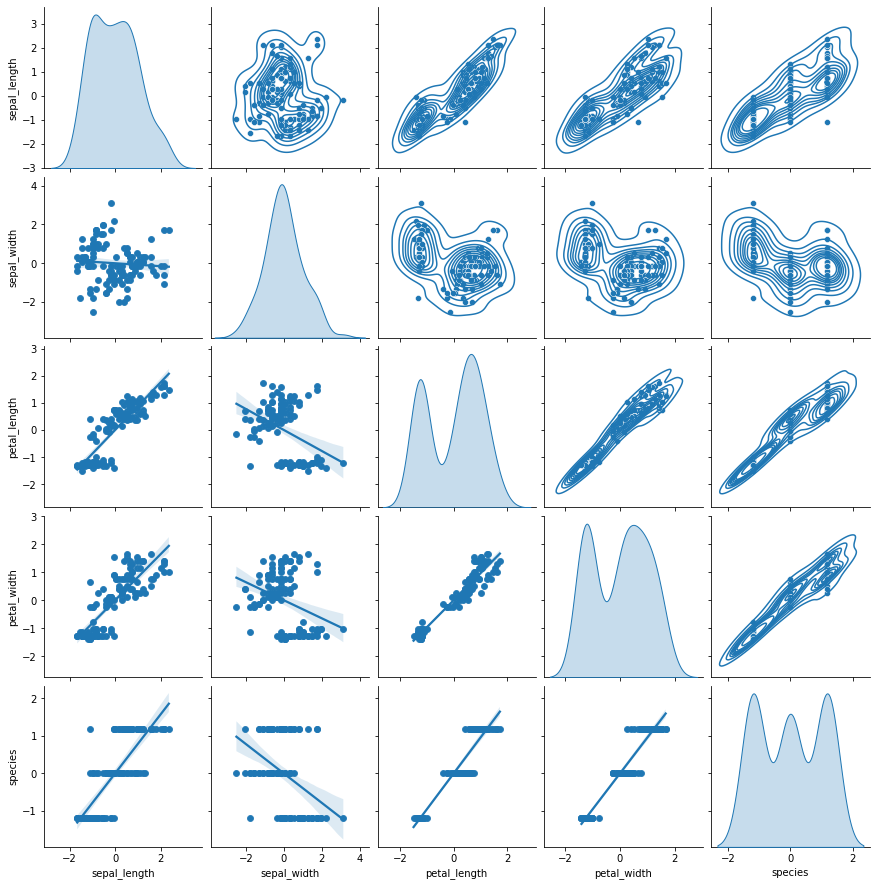

In [16]:
# 先要預處理數據

def norm(x):
    stats = x.describe().transpose()
    return (x - stats['mean']) / stats['std']

# 留一份 stats 數據，後面可以推回來

iris_stats = iris.describe().transpose()
print(iris_stats)

# Norm boston_data

normed_iris= norm(iris)

# 這個酷

pp = sb.pairplot(normed_iris, diag_kind='kde')
pp = pp.map_lower(sb.regplot)
pp = pp.map_upper(sb.kdeplot)

In [17]:
# Check corr

correlation_data = normed_iris.corr()
correlation_data.style.background_gradient(cmap='coolwarm', axis=None)

In [18]:
X = normed_iris.iloc[:, 0:-1]
y = iris.iloc[:, -1]

In [19]:
# Split data, 用 85% train + validation, 15% test

X_trainvalid, X_test, y_trainvalid, y_test = train_test_split(X, y, test_size=0.15, random_state=1)

# 再分一次，把 
X_train, X_valid, y_train, y_valid = train_test_split(X_trainvalid, y_trainvalid, test_size=0.15, random_state=1)

print(X_train.shape, X_valid.shape, X_test.shape)

(86, 4) (16, 4) (18, 4)


## Model

![](ex/2021-06-18_162933.png)

In [44]:
#built the neural network architecture，先直接接 output
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(10, input_shape=(4,) , activation='relu'))
model.add(tf.keras.layers.Dense(10, activation='linear'))
model.add(tf.keras.layers.Dense(3, activation='softmax'))

# mse = mean square error, mae = mean absolute error, 可以試一試 SGD, adam, adagrad, momentum, adadelta, RMSprop
model.compile(optimizer='SGD', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# overfitting control
early_stopping = tf.keras.callbacks.EarlyStopping(patience=2)

#train the neural network on the train dataset
history = model.fit(X_train, y_train, batch_size=50, epochs = 200, validation_data=(X_valid, y_valid), callbacks=[early_stopping], verbose = 2)

Epoch 1/200
2/2 - 0s - loss: 1.2835 - accuracy: 0.1163 - val_loss: 1.2398 - val_accuracy: 0.1875
Epoch 2/200
2/2 - 0s - loss: 1.2441 - accuracy: 0.1395 - val_loss: 1.1994 - val_accuracy: 0.1875
Epoch 3/200
2/2 - 0s - loss: 1.2069 - accuracy: 0.1628 - val_loss: 1.1614 - val_accuracy: 0.1875
Epoch 4/200
2/2 - 0s - loss: 1.1724 - accuracy: 0.2209 - val_loss: 1.1245 - val_accuracy: 0.2500
Epoch 5/200
2/2 - 0s - loss: 1.1411 - accuracy: 0.2442 - val_loss: 1.0915 - val_accuracy: 0.3125
Epoch 6/200
2/2 - 0s - loss: 1.1106 - accuracy: 0.2674 - val_loss: 1.0597 - val_accuracy: 0.3125
Epoch 7/200
2/2 - 0s - loss: 1.0824 - accuracy: 0.3023 - val_loss: 1.0296 - val_accuracy: 0.3125
Epoch 8/200
2/2 - 0s - loss: 1.0567 - accuracy: 0.3372 - val_loss: 1.0036 - val_accuracy: 0.3125
Epoch 9/200
2/2 - 0s - loss: 1.0317 - accuracy: 0.3837 - val_loss: 0.9777 - val_accuracy: 0.3125
Epoch 10/200
2/2 - 0s - loss: 1.0085 - accuracy: 0.3953 - val_loss: 0.9532 - val_accuracy: 0.3750
Epoch 11/200
2/2 - 0s - loss:

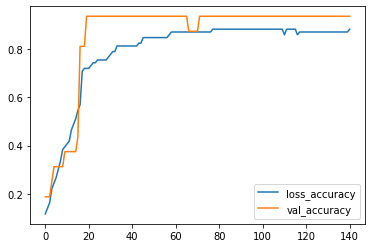

In [45]:
import matplotlib.pyplot as plt
%matplotlib inline

#plot the loss and validation loss of the dataset
history_df = pd.DataFrame(history.history)
plt.plot(history_df['accuracy'], label='loss_accuracy')
plt.plot(history_df['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

## Result

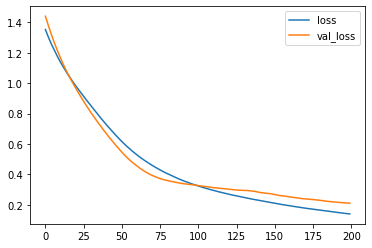

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

#plot the loss and validation loss of the dataset
history_df = pd.DataFrame(history.history)
plt.plot(history_df['loss'], label='loss')
plt.plot(history_df['val_loss'], label='val_loss')

plt.legend()

In [23]:
#evaluate the model

result = model.evaluate(X_test, y_test, batch_size=10)

print(result)

2/2 [==============================] - 0s 3ms/step - loss: 0.2259 - accuracy: 0.8889
[0.2259172648191452, 0.8888888955116272]


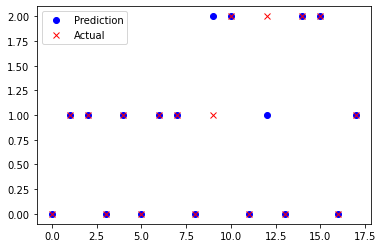

In [34]:
y_pred = model.predict(X_test)
# 這邊 tricky 的地方是, softmax 產出的是一個 matrix, 是機率，要轉成 argmax 
y_pred = np.argmax(y_pred, axis = 1)
y_test = np.array(y_test)

plt.plot(y_pred, 'bo', label='Prediction')
plt.plot(y_test, 'rx', label='Actual')
plt.legend()
plt.show()

# Fasion mnist(ANN VS CNN)


In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
print(tf.__version__)

2.4.0


In [2]:
(train_images, train_labels), (test_images, test_labels) = keras.datasets.fashion_mnist.load_data()
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [3]:
# 看一下數據
print(train_images.shape,train_labels.shape)

(60000, 28, 28) (60000,)


In [4]:
train_images = train_images.reshape([-1,28,28]) / 255.0
test_images = test_images.reshape([-1,28,28]) / 255.0

## Model1 (1 hidden)

In [9]:
model = keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=(28,28)))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(10, activation='softmax'))

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                25120     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                330       
Total params: 25,450
Trainable params: 25,450
Non-trainable params: 0
_________________________________________________________________
None


In [10]:
# mse = mean square error, mae = mean absolute error, 可以試一試 SGD, adam, adagrad, momentum, adadelta, RMSprop
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs = 20)

Epoch 1/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.7212 - accuracy: 0.7533
Epoch 2/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.4196 - accuracy: 0.8534
Epoch 3/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3825 - accuracy: 0.8645
Epoch 4/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3515 - accuracy: 0.8740
Epoch 5/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3409 - accuracy: 0.8782
Epoch 6/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3277 - accuracy: 0.8818
Epoch 7/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3157 - accuracy: 0.8840
Epoch 8/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3128 - accuracy: 0.8850
Epoch 9/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3047 - accuracy: 0.8877
Epoch 10/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.297

In [9]:
## Result1

test_loss, test_accuracy = model.evaluate(test_images, test_labels)

313/313 [==============================] - 1s 1ms/step - loss: 0.3612 - accuracy: 0.8761


## Model2 (3 Hidden)

In [10]:
model = keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=(28,28)))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dense(192, activation='relu'))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(10, activation='softmax'))

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               200960    
_________________________________________________________________
dense_3 (Dense)              (None, 192)               49344     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               24704     
_________________________________________________________________
dense_5 (Dense)              (None, 10)                1290      
Total params: 276,298
Trainable params: 276,298
Non-trainable params: 0
_________________________________________________________________
None


In [11]:
# mse = mean square error, mae = mean absolute error, 可以試一試 SGD, adam, adagrad, momentum, adadelta, RMSprop
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs = 20)

Epoch 1/20
1875/1875 [==============================] - 5s 2ms/step - loss: 0.6136 - accuracy: 0.7817
Epoch 2/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3705 - accuracy: 0.8630
Epoch 3/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3259 - accuracy: 0.8773
Epoch 4/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3076 - accuracy: 0.8856
Epoch 5/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2803 - accuracy: 0.8955
Epoch 6/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2699 - accuracy: 0.8997
Epoch 7/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2603 - accuracy: 0.9040
Epoch 8/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2422 - accuracy: 0.9075
Epoch 9/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2375 - accuracy: 0.9121
Epoch 10/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.227

## Model3 CNN

In [15]:
# 之前用 ANN, 圖片要 flatten，但用 CNN 要 reshape 回去 
train_images = train_images.reshape([60000,28,28,1]) 
test_images = test_images.reshape([10000,28,28,1]) 

# First layer—convolutional layer with ReLU activation function: 
# This layer takes the 2D array (28 × 28 pixels) as input. 
# We will take 50 convolutional kernels (filters) of shape 3 × 3 pixels. 
# The output of which will be passed to a ReLU activation function before beingpassed to the next layer.

In [26]:
model_cnn = tf.keras.models.Sequential()
model_cnn.add(tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)))
# 第二層用 maxpolling layers > 28 被 3 掃過去，會有 26X26, 用 (2X2) 縮為 50X13X13
model_cnn.add(tf.keras.layers.MaxPooling2D((2,2)))
# 第三層把它轉成 flattern 的 1D array
model_cnn.add(tf.keras.layers.Flatten())
model_cnn.add(tf.keras.layers.Dense(100, activation='relu'))
model_cnn.add(tf.keras.layers.Dense(10, activation='softmax'))
print(model_cnn.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 5408)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 100)               540900    
_________________________________________________________________
dense_9 (Dense)              (None, 10)                1010      
Total params: 542,230
Trainable params: 542,230
Non-trainable params: 0
_________________________________________________________________
None


In [27]:
model_cnn.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])
opt = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
history = model_cnn.fit(train_images, train_labels, epochs=10)

Epoch 1/10


ValueError: in user code:

    c:\users\clin8\myapp\python\ai\lib\site-packages\tensorflow\python\keras\engine\training.py:805 train_function  *
        return step_function(self, iterator)
    c:\users\clin8\myapp\python\ai\lib\site-packages\tensorflow\python\keras\engine\training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    c:\users\clin8\myapp\python\ai\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    c:\users\clin8\myapp\python\ai\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    c:\users\clin8\myapp\python\ai\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    c:\users\clin8\myapp\python\ai\lib\site-packages\tensorflow\python\keras\engine\training.py:788 run_step  **
        outputs = model.train_step(data)
    c:\users\clin8\myapp\python\ai\lib\site-packages\tensorflow\python\keras\engine\training.py:755 train_step
        loss = self.compiled_loss(
    c:\users\clin8\myapp\python\ai\lib\site-packages\tensorflow\python\keras\engine\compile_utils.py:203 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    c:\users\clin8\myapp\python\ai\lib\site-packages\tensorflow\python\keras\losses.py:152 __call__
        losses = call_fn(y_true, y_pred)
    c:\users\clin8\myapp\python\ai\lib\site-packages\tensorflow\python\keras\losses.py:256 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    c:\users\clin8\myapp\python\ai\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    c:\users\clin8\myapp\python\ai\lib\site-packages\tensorflow\python\keras\losses.py:1537 categorical_crossentropy
        return K.categorical_crossentropy(y_true, y_pred, from_logits=from_logits)
    c:\users\clin8\myapp\python\ai\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    c:\users\clin8\myapp\python\ai\lib\site-packages\tensorflow\python\keras\backend.py:4833 categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)
    c:\users\clin8\myapp\python\ai\lib\site-packages\tensorflow\python\framework\tensor_shape.py:1134 assert_is_compatible_with
        raise ValueError("Shapes %s and %s are incompatible" % (self, other))

    ValueError: Shapes (32, 1) and (32, 10) are incompatible


In [68]:
train_images.shape

(60000, 28, 28, 1)

In [12]:
test_loss, test_accuracy = model.evaluate(test_images, test_labels)

313/313 [==============================] - 1s 2ms/step - loss: 0.3769 - accuracy: 0.8888


In [18]:
test_pred = model.predict(test_images)

In [19]:
test_pred = np.argmax(test_pred, axis = 1)
test_pred

array([9, 2, 1, ..., 8, 1, 5], dtype=int64)

In [20]:
test_labels

array([9, 2, 1, ..., 8, 1, 5], dtype=uint8)

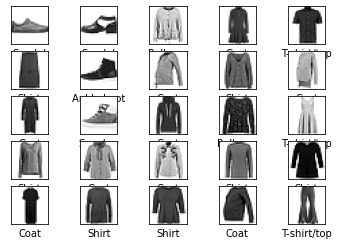

In [23]:
j = 1
for i in range(1000):
#     print(test_pred[i], test_labels[i])
    if test_pred[i] != test_labels[i]:
        plt.subplot(5,5,j)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(test_images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[test_pred[i]], fontdict=)
        j +=1
        
        if j > 25:
            break
            
plt.show()
        
    

# Basic Regression Auto MPG

In [11]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
from tensorflow.keras import layers

tf.executing_eagerly = True

print('Tensorflow Version: ' + tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Tensorflow Version: 2.4.0
Num GPUs Available:  1


## Prepare

In [2]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

'C:\\Users\\clin8\\.keras\\datasets\\auto-mpg.data'

In [3]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight','Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

auto_mpg = raw_dataset.copy()
auto_mpg.tail()

MPG  Cylinders  Displacement  Horsepower  Weight  Acceleration  \
393  27.0          4         140.0        86.0  2790.0          15.6   
394  44.0          4          97.0        52.0  2130.0          24.6   
395  32.0          4         135.0        84.0  2295.0          11.6   
396  28.0          4         120.0        79.0  2625.0          18.6   
397  31.0          4         119.0        82.0  2720.0          19.4   

     Model Year  Origin  
393          82       1  
394          82       2  
395          82       1  
396          82       1  
397          82       1

In [4]:
auto_mpg.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [5]:
# Null 要處理掉

auto_mpg = auto_mpg.dropna()

              count         mean         std     min       25%      50%  \
MPG           392.0    23.445918    7.805007     9.0    17.000    22.75   
Cylinders     392.0     5.471939    1.705783     3.0     4.000     4.00   
Displacement  392.0   194.411990  104.644004    68.0   105.000   151.00   
Horsepower    392.0   104.469388   38.491160    46.0    75.000    93.50   
Weight        392.0  2977.584184  849.402560  1613.0  2225.250  2803.50   
Acceleration  392.0    15.541327    2.758864     8.0    13.775    15.50   
Model Year    392.0    75.979592    3.683737    70.0    73.000    76.00   
Origin        392.0     1.576531    0.805518     1.0     1.000     1.00   

                   75%     max  
MPG             29.000    46.6  
Cylinders        8.000     8.0  
Displacement   275.750   455.0  
Horsepower     126.000   230.0  
Weight        3614.750  5140.0  
Acceleration    17.025    24.8  
Model Year      79.000    82.0  
Origin           2.000     3.0  


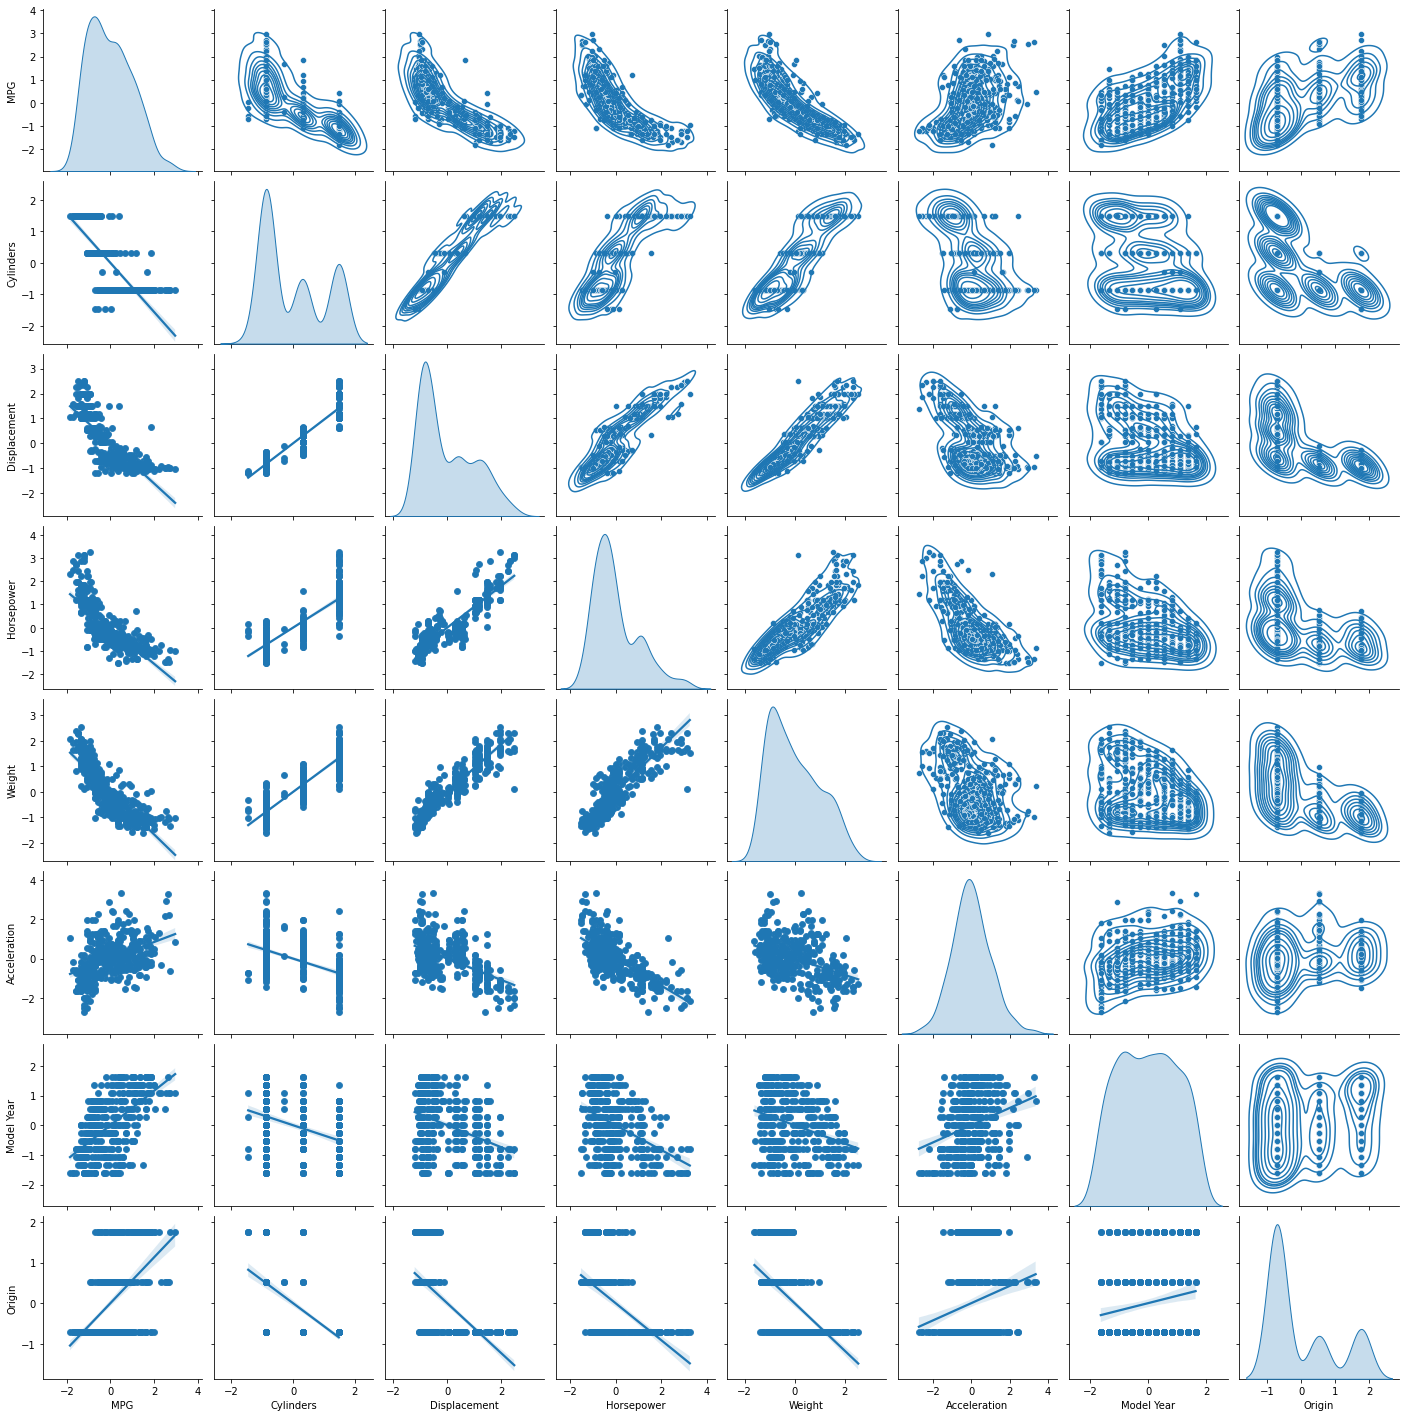

In [6]:
# 先要預處理數據

def norm(x):
    stats = x.describe().transpose()
    return (x - stats['mean']) / stats['std']

# 留一份 stats 數據，後面可以推回來

auto_mpg_stats = auto_mpg.describe().transpose()
print(auto_mpg_stats)

# Norm boston_data

normed_auto= norm(auto_mpg)

# 這個酷

pp = sns.pairplot(normed_auto, diag_kind='kde')
pp = pp.map_lower(sns.regplot)
pp = pp.map_upper(sns.kdeplot)

In [7]:
# 從圖上看到，origin 很徧，而且 origin 1 為美國，2 歐洲，3 日本 會有順序性，應轉化為 one-hot
# 重做 data clean
# 這個技巧要學起來，很好用，把一個列變成 one-hot

origin = auto_mpg.pop('Origin')
auto_mpg['USA'] = (origin == 1)*1.0
auto_mpg['Europe'] = (origin == 2)*1.0
auto_mpg['Japan'] = (origin == 3)*1.0
auto_mpg.tail()

MPG  Cylinders  Displacement  Horsepower  Weight  Acceleration  \
393  27.0          4         140.0        86.0  2790.0          15.6   
394  44.0          4          97.0        52.0  2130.0          24.6   
395  32.0          4         135.0        84.0  2295.0          11.6   
396  28.0          4         120.0        79.0  2625.0          18.6   
397  31.0          4         119.0        82.0  2720.0          19.4   

     Model Year  USA  Europe  Japan  
393          82  1.0     0.0    0.0  
394          82  0.0     1.0    0.0  
395          82  1.0     0.0    0.0  
396          82  1.0     0.0    0.0  
397          82  1.0     0.0    0.0

## 拆分數據集的好用法

pandas.dataframe.sample

In [8]:
# 把資料分為約莫 Train 80%, test 20%

train_data = auto_mpg.sample(frac=0.80, random_state=10)
test_data = auto_mpg.drop(train_data.index)
train_label = train_data.pop('MPG')
test_label = test_data.pop('MPG')

In [9]:
# 我們應該 based on 同樣的方法來做 normalize，而不是根據個自的 mean, std - 因為數量不同會有差異，尤其 std
# 我們用 auto_mpg_stats 來 mapping
# 但，有點麻煩呢

normed_train_data = norm(train_data)
normed_test_data = norm(test_data)
print(normed_train_data.shape, normed_test_data.shape)

(314, 9) (78, 9)


## Model with tuning

In [33]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(64, input_shape=(9,), activation = 'relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))

# 很妙的是，加了這一層，不但速度慢，而且結果也差…不懂
# 多跑了幾次，發現運氣、機率蠻重要，然後 early stop 也有時候會誤算
# model.add(tf.keras.layers.Dense(6, activation='relu'))
# 嘗試在第二層做優化


model.add(tf.keras.layers.Dense(1, activation='linear'))

print(model.summary())

optimizer = tf.keras.optimizers.RMSprop(0.001)
model.compile(loss='mse', optimizer = optimizer, metrics=['mae','mse'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                640       
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________
None


In [36]:
# Use model builder

def model_builder(hp):
    model = keras.Sequential()
    model.add(tf.keras.layers.Dense(64, input_shape=(9,), activation = 'relu'))
    
    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-512
    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
    
    model.add(keras.layers.Dense(units=hp_units, activation='relu'))
    
    model.add(tf.keras.layers.Dense(1, activation='linear'))

    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    optimizer = tf.keras.optimizers.RMSprop(hp_learning_rate)
    model.compile(loss='mse', optimizer = optimizer, metrics=['mae','mse'])

    return model

tuner = kt.Hyperband(model_builder,
                     objective=kt.Objective("loss", direction="min"),
                     max_epochs=100,
                     factor=3,
                     directory='./ex',
                     project_name='keras_tuner_1')

# overfitting control
early_stopping = tf.keras.callbacks.EarlyStopping(patience=5)

#train the neural network on the train dataset

tuner.search(normed_train_data, train_label, batch_size=50, epochs=100, validation_split=0.2, callbacks=[early_stopping])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

Trial 48 Complete [00h 00m 00s]
loss: 592.8685913085938

Best loss So Far: 16.066526412963867
Total elapsed time: 00h 00m 44s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 128 and the optimal learning rate for the optimizer
is 0.01.



In [37]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model_tuner = tuner.hypermodel.build(best_hps)
history = model.fit(normed_train_data, train_label, batch_size = 50, epochs=100, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/100
6/6 [==============================] - 0s 17ms/step - loss: 10.2780 - mae: 2.4771 - mse: 10.2780 - val_loss: 13.0962 - val_mae: 2.5428 - val_mse: 13.0962
Epoch 2/100
6/6 [==============================] - 0s 9ms/step - loss: 9.9771 - mae: 2.4227 - mse: 9.9771 - val_loss: 19.8997 - val_mae: 3.2704 - val_mse: 19.8997
Epoch 3/100
6/6 [==============================] - 0s 9ms/step - loss: 10.7735 - mae: 2.5444 - mse: 10.7735 - val_loss: 17.8338 - val_mae: 3.0468 - val_mse: 17.8338
Epoch 4/100
6/6 [==============================] - 0s 9ms/step - loss: 10.2743 - mae: 2.4921 - mse: 10.2743 - val_loss: 14.3221 - val_mae: 2.8212 - val_mse: 14.3221
Epoch 5/100
6/6 [==============================] - 0s 9ms/step - loss: 9.4320 - mae: 2.4034 - mse: 9.4320 - val_loss: 12.7518 - val_mae: 2.5952 - val_mse: 12.7518
Epoch 6/100
6/6 [==============================] - 0s 9ms/step - loss: 9.1056 - mae: 2.3328 - mse: 9.1056 - val_loss: 10.3769 - val_mae: 2.3895 - val_mse: 10.3769
Epoch 7/100
6/6

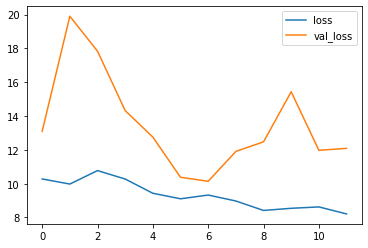

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline

#plot the loss and validation loss of the dataset
history_df = pd.DataFrame(history.history)
plt.plot(history_df['loss'], label='loss')
plt.plot(history_df['val_loss'], label='val_loss')

plt.legend()

## Verify Keras Tuner

In [45]:
# Let's rewrite the model with best in class hyper-parameter

model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(64, input_shape=(9,), activation = 'relu'))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='linear'))
print(model.summary())

optimizer = tf.keras.optimizers.RMSprop(0.01)
model.compile(loss='mse', optimizer = optimizer, metrics=['mae','mse'])

# overfitting control
early_stopping = tf.keras.callbacks.EarlyStopping(patience=5)

#train the neural network on the train dataset
history = model.fit(normed_train_data, train_label, batch_size=50, epochs = 100, 
                    validation_split=0.2, callbacks=[early_stopping])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 64)                640       
_________________________________________________________________
dense_13 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 129       
Total params: 9,089
Trainable params: 9,089
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
6/6 [==============================] - 1s 32ms/step - loss: 378.8750 - mae: 16.7439 - mse: 378.8750 - val_loss: 111.1266 - val_mae: 8.5298 - val_mse: 111.1266
Epoch 2/100
6/6 [==============================] - 0s 10ms/step - loss: 75.4997 - mae: 6.4802 - mse: 75.4997 - val_loss: 35.2974 - val_mae: 4.7685 - val_mse: 35.2974
Epoch 3/100
6/6 [=======================

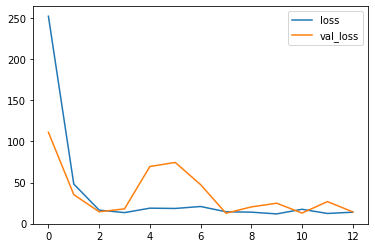

In [46]:
import matplotlib.pyplot as plt
%matplotlib inline

#plot the loss and validation loss of the dataset
history_df = pd.DataFrame(history.history)
plt.plot(history_df['loss'], label='loss')
plt.plot(history_df['val_loss'], label='val_loss')

plt.legend()

In [47]:
loss, mae, mse = model.evaluate(normed_test_data, test_label, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

3/3 - 0s - loss: 22.4836 - mae: 3.8110 - mse: 22.4836
Testing set Mean Abs Error:  3.81 MPG


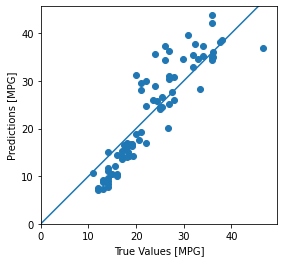

In [48]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_label, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

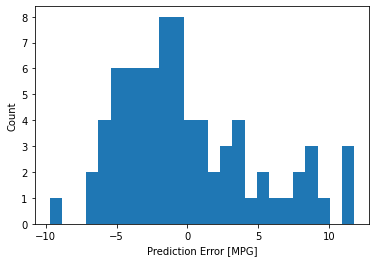

In [49]:
error = test_predictions - test_label
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

# 儲存 Model 和 Weights

pip install pyyaml, h5py

## 訓練時使用

checkpoint_path = "training_1/cp.ckpt"

checkpoint_dir = os.path.dirname(checkpoint_path)

创建一个保存模型权重的回调

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

使用新的回调训练模型

model.fit(train_images, 
          train_labels,  
          epochs=10,
          validation_data=(test_images,test_labels),
          callbacks=[cp_callback])  # 通过回调训练

这可能会生成与保存优化程序状态相关的警告。
这些警告（以及整个笔记本中的类似警告）
是防止过时使用，可以忽略。

## 訓練完成時用法

In [21]:
model.save_weights('./ex/auto_mpg_weight')

## 重新啟用時呼叫

In [22]:
# 重建 model

model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(64, input_shape=(9,), activation = 'relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))

# 很妙的是，加了這一層，不但速度慢，而且結果也差…不懂
# 多跑了幾次，發現運氣、機率蠻重要，然後 early stop 也有時候會誤算
# model.add(tf.keras.layers.Dense(6, activation='relu'))

model.add(tf.keras.layers.Dense(1, activation='linear'))

print(model.summary())

optimizer = tf.keras.optimizers.RMSprop(0.001)
model.compile(loss='mse', optimizer = optimizer, metrics=['mae','mse'])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 64)                640       
_________________________________________________________________
dense_10 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________
None


In [23]:
# Load weight

model.load_weights('./ex/auto_mpg_weight')

In [ ]:
# 可以或繼續訓練

# CIFAR10 CNN

CNN 的输入是张量 (Tensor) 形式的 (image_height, image_width, color_channels)，包含了图像高度、宽度及颜色信息。不需要输入 batch size。如果您不熟悉图像处理，颜色信息建议您使用 RGB 色彩模式，此模式下，color_channels 为 (R,G,B) 分别对应 RGB 的三个颜色通道（color channel）。在此示例中，我们的 CNN 输入，CIFAR 数据集中的图片，形状是 (32, 32, 3)。您可以在声明第一层时将形状赋值给参数 input_shape 。

In [17]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

%matplotlib inline
tf.executing_eagerly = True
print('Tensorflow Version: ' + tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Tensorflow Version: 2.4.0
Num GPUs Available:  1


## CNN 必跑這一段…

In [18]:
def set_tensorflow_config(per_process_gpu_memory_fraction=0.8):
    config = tf.compat.v1.ConfigProto()
    # config = tf.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = per_process_gpu_memory_fraction
    config.gpu_options.allow_growth=True
    # sess = tf.Session(config=config)
    sess = tf.compat.v1.Session(config=config)
    
    print("== TensorFlow Config options set ==")
    print("\nThis process will now utilize {} GPU Memeory Fraction".format(per_process_gpu_memory_fraction))

set_tensorflow_config()

== TensorFlow Config options set ==

This process will now utilize 0.8 GPU Memeory Fraction


In [10]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# 将像素的值标准化至0到1的区间内。
train_images, test_images = train_images / 255.0, test_images / 255.0

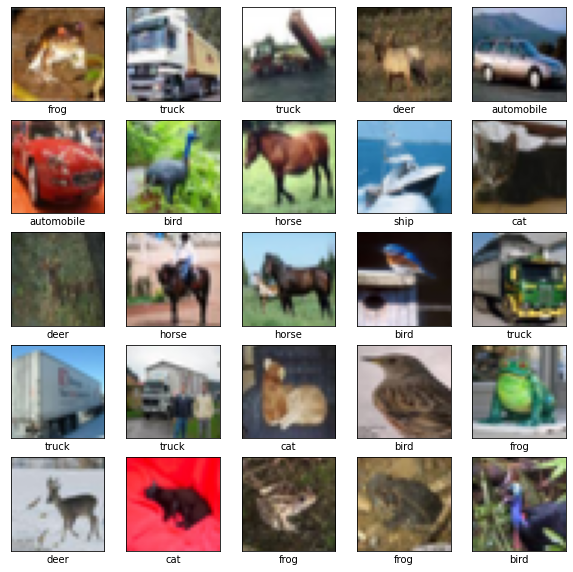

In [11]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    # 由于 CIFAR 的标签是 array， 
    # 因此您需要额外的索引（index）。
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

## Model1

In [32]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 4, 4, 64)          36928     
Total params: 56,320
Trainable params: 56,320
Non-trainable params: 0
_________________________________________________________________


In [33]:

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_8 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_22 (Dense)             (None, 64)               

In [34]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=20, validation_split=0.2)

Epoch 1/20
1250/1250 [==============================] - 6s 4ms/step - loss: 1.8014 - accuracy: 0.3337 - val_loss: 1.2960 - val_accuracy: 0.5346
Epoch 2/20
1250/1250 [==============================] - 5s 4ms/step - loss: 1.2432 - accuracy: 0.5535 - val_loss: 1.1109 - val_accuracy: 0.6079
Epoch 3/20
1250/1250 [==============================] - 5s 4ms/step - loss: 1.0507 - accuracy: 0.6304 - val_loss: 1.0459 - val_accuracy: 0.6339
Epoch 4/20
1250/1250 [==============================] - 5s 4ms/step - loss: 0.9215 - accuracy: 0.6731 - val_loss: 0.9670 - val_accuracy: 0.6599
Epoch 5/20
1250/1250 [==============================] - 5s 4ms/step - loss: 0.8442 - accuracy: 0.7069 - val_loss: 0.9161 - val_accuracy: 0.6780
Epoch 6/20
1250/1250 [==============================] - 5s 4ms/step - loss: 0.7624 - accuracy: 0.7338 - val_loss: 0.9582 - val_accuracy: 0.6737
Epoch 7/20
1250/1250 [==============================] - 5s 4ms/step - loss: 0.7098 - accuracy: 0.7512 - val_loss: 0.8927 - val_accuracy:

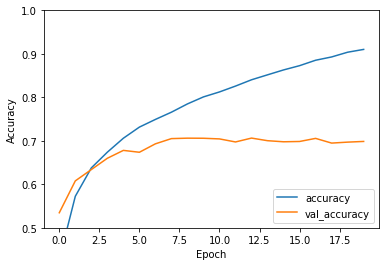

313/313 - 1s - loss: 1.4273 - accuracy: 0.6865


In [35]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

In [36]:
test_loss, test_accuracy = model.evaluate(test_images, test_labels)

313/313 [==============================] - 1s 2ms/step - loss: 1.4273 - accuracy: 0.6865


## Model 2


In [46]:
model = tf.keras.models.Sequential()
model.add(layers.Conv2D(filters=32,kernel_size=(3,3),input_shape=(32,32,3),activation='relu',padding='same'))
model.add(layers.Dropout(0.3))
model.add(layers.Conv2D(filters=32,kernel_size=(3,3),activation='relu',padding='same'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))

#第二次
model.add(layers.Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding='same'))
model.add(layers.Dropout(0.3))
model.add(layers.Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding='same'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))

#第三次
model.add(layers.Conv2D(filters=128,kernel_size=(3,3),activation='relu',padding='same'))
model.add(layers.Dropout(0.3))
model.add(layers.Conv2D(filters=128,kernel_size=(3,3),activation='relu',padding='same'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))

model.summary()


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
dropout_33 (Dropout)         (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
dropout_34 (Dropout)         (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 16, 16, 64)       

In [47]:
model.add(layers.Flatten())
model.add(layers.Dropout(0.3))
model.add(layers.Dense(512,activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(128,activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(10,activation='softmax'))

model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
dropout_33 (Dropout)         (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
dropout_34 (Dropout)         (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 16, 16, 64)       

In [48]:
#開始訓練
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# overfitting control
early_stopping = tf.keras.callbacks.EarlyStopping(patience=5)

history = model.fit(train_images, train_labels, validation_split=0.2, epochs=20, batch_size=128, callbacks=[early_stopping], verbose=1)

model.save_weights('./ex/cifarCnnModel.h5')

Epoch 1/20
313/313 [==============================] - 4s 11ms/step - loss: 2.0604 - accuracy: 0.2197 - val_loss: 1.5134 - val_accuracy: 0.4459
Epoch 2/20
313/313 [==============================] - 3s 11ms/step - loss: 1.5011 - accuracy: 0.4451 - val_loss: 1.2723 - val_accuracy: 0.5500
Epoch 3/20
313/313 [==============================] - 3s 11ms/step - loss: 1.2471 - accuracy: 0.5527 - val_loss: 1.1094 - val_accuracy: 0.6036
Epoch 4/20
313/313 [==============================] - 3s 11ms/step - loss: 1.1136 - accuracy: 0.6115 - val_loss: 0.9772 - val_accuracy: 0.6533
Epoch 5/20
313/313 [==============================] - 3s 11ms/step - loss: 0.9983 - accuracy: 0.6495 - val_loss: 0.8965 - val_accuracy: 0.6799
Epoch 6/20
313/313 [==============================] - 3s 11ms/step - loss: 0.9164 - accuracy: 0.6798 - val_loss: 0.8657 - val_accuracy: 0.7027
Epoch 7/20
313/313 [==============================] - 3s 11ms/step - loss: 0.8523 - accuracy: 0.7022 - val_loss: 0.7719 - val_accuracy: 0.7318

In [43]:
# 

try:
    model.load_weights('./ex/cifarCnnModel.h5')
    print("載入模型成功")
except:
    print("載入模型失敗")

history =  model.fit(train_images, train_labels, validation_split=0.2, epochs=5, batch_size=128, verbose=1)

model.save_weights('./ex/cifarCnnModel.h5')

載入模型失敗
Epoch 1/5
313/313 [==============================] - 4s 11ms/step - loss: 0.6689 - accuracy: 0.7652 - val_loss: 0.6867 - val_accuracy: 0.7622
Epoch 2/5
313/313 [==============================] - 3s 11ms/step - loss: 0.6529 - accuracy: 0.7720 - val_loss: 0.6579 - val_accuracy: 0.7762
Epoch 3/5
313/313 [==============================] - 3s 11ms/step - loss: 0.6235 - accuracy: 0.7824 - val_loss: 0.6441 - val_accuracy: 0.7787
Epoch 4/5
313/313 [==============================] - 3s 11ms/step - loss: 0.6144 - accuracy: 0.7860 - val_loss: 0.6438 - val_accuracy: 0.7786
Epoch 5/5
313/313 [==============================] - 3s 11ms/step - loss: 0.5840 - accuracy: 0.7963 - val_loss: 0.6356 - val_accuracy: 0.7860


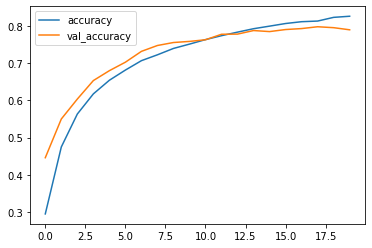

In [52]:
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

#plot the loss and validation loss of the dataset
history_df = pd.DataFrame(history.history)
plt.plot(history_df['accuracy'], label='accuracy')
plt.plot(history_df['val_accuracy'], label='val_accuracy')

plt.legend()

In [53]:
test_loss, test_accuracy = model.evaluate(test_images, test_labels)

313/313 [==============================] - 1s 3ms/step - loss: 0.6439 - accuracy: 0.7839


# Next Case